In [ ]:
!pip install opendatasets
!pip install opencv-python
!pip install adversarial-robustness-toolbox
!pip install tabulate
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 53.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.17.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.2 MB/s eta 0:00:00


In [ ]:
#Importing required libraries.

import numpy as np
import pandas as pd
import os
import cv2
import opendatasets as od
import matplotlib.pyplot as plt

In [ ]:
od.download("https://www.kaggle.com/datasets/dheerajperumandla/drowsiness-dataset/train", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: moinkhan3012
Your Kaggle Key: ··········


100%|██████████| 161M/161M [00:00<00:00, 221MB/s]


We've defined a function that reads in driver drowsiness detection images from a specified directory. The function iterates over the "Closed" and "Open" categories of images, resizes each image array to 224x224 pixels, and appends it with its corresponding class label (0 or 1 for "Closed" or "Open", respectively) to a list called `data`. The function returns the `data` list containing all the resized images with their corresponding class labels for all the images in the specified directory.

In [ ]:
def get_data(dir_path="./drowsiness-dataset/train/"):
    # Define the labels for the data
    categories = ['Closed', 'Open']
    # Define the size of the images after resizing
    IMG_SIZE = 224
    images, labels = [], []

    # Loop through each label in the labels list
    for category in categories:
        class_num = categories.index(category)  # assign a unique class number to each category

        # Define the path to the label's directory
        path = os.path.join(dir_path, category)
        # Get the index of the label in the labels list
        # Loop through each image in the label's directory

        for img in os.listdir(path):
            try:
                # Read in the image and resize it
                image_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
                resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
                # Append the resized image and its label to the data list
                images.append(resized_array)
                labels.append(class_num)
            except Exception as e:
                print(e)

    images = np.concatenate([images])
    labels = np.concatenate([labels])

    # Return the list of data
    return images, labels


In [ ]:
X,y = get_data()


In [ ]:
#Preprocess the data
X = X/255.0

### One-hot encoding the labels





In [ ]:
y = np.array([np.array([1, 0]) if label == 0 else np.array([0, 1]) for label in y])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Splitting data into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [ ]:
import numpy as np

if not os.path.exists('processed_data/'):
    os.makedirs('processed_data/')

# Save X_train, X_test, y_train, y_test
np.save('/content/drive/MyDrive/MLCS_Project_SavedModels/Data/processed_data/X_train.npy', X_train)
np.save('/content/drive/MyDrive/MLCS_Project_SavedModels/Data/processed_data/X_test.npy', X_test)
np.save('/content/drive/MyDrive/MLCS_Project_SavedModels/Data/processed_data/y_train.npy', y_train)
np.save('/content/drive/MyDrive/MLCS_Project_SavedModels/Data/processed_data/y_test.npy', y_test)


In [ ]:
# Load the data back
import numpy as np
X_train = np.load('/content/drive/MyDrive/MLCS_Project_SavedModels/Data/processed_data/X_train.npy')
X_test = np.load('/content/drive/MyDrive/MLCS_Project_SavedModels/Data/processed_data/X_test.npy')
y_train = np.load('/content/drive/MyDrive/MLCS_Project_SavedModels/Data/processed_data/y_train.npy')
y_test = np.load('/content/drive/MyDrive/MLCS_Project_SavedModels/Data/processed_data/y_test.npy')

In [ ]:
y_train.shape

(1016, 2)

# Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator()

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model


In [ ]:
import tensorflow as tf

base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Add custom top layers for your specific task
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Create the new model
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                              

## Training the model

In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator, shuffle=True)

Epoch 1/10
32/32 [==============================] - 39s 461ms/step - loss: 0.1336 - accuracy: 0.9577 - val_loss: 0.0697 - val_accuracy: 0.9908
Epoch 2/10
32/32 [==============================] - 15s 459ms/step - loss: 0.0223 - accuracy: 0.9931 - val_loss: 0.1330 - val_accuracy: 0.9817
Epoch 3/10
32/32 [==============================] - 14s 421ms/step - loss: 0.0123 - accuracy: 0.9961 - val_loss: 0.0095 - val_accuracy: 0.9977
Epoch 4/10
32/32 [==============================] - 25s 757ms/step - loss: 0.0013 - accuracy: 0.9990 - val_loss: 0.0060 - val_accuracy: 0.9977
Epoch 5/10
32/32 [==============================] - 14s 446ms/step - loss: 0.0041 - accuracy: 0.9970 - val_loss: 0.0197 - val_accuracy: 0.9977
Epoch 6/10
32/32 [==============================] - 14s 449ms/step - loss: 0.0540 - accuracy: 0.9882 - val_loss: 0.7462 - val_accuracy: 0.8968
Epoch 7/10
32/32 [==============================] - 12s 381ms/step - loss: 0.0264 - accuracy: 0.9921 - val_loss: 0.1083 - val_accuracy: 0.9862

In [ ]:
model.save("/content/drive/MyDrive/MLCS_Project_SavedModels/driver_drowsiness_mobilenet_imagenet_eyes_open_closed.keras")

# Evaluations

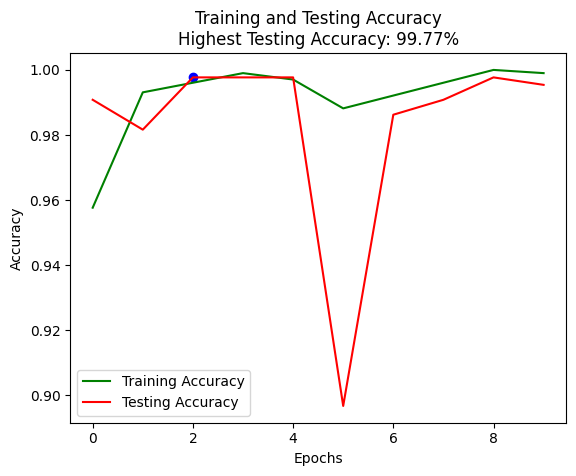

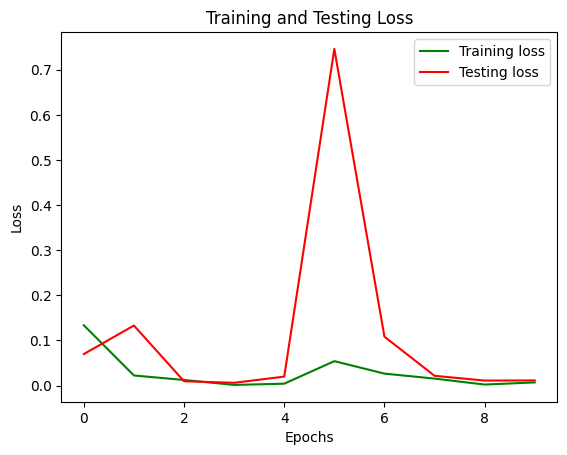

In [ ]:
# Extracting the accuracy and loss values from the training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# Finding the index and value of the highest testing accuracy
max_val_acc = max(val_accuracy)
max_val_acc_index = val_accuracy.index(max_val_acc)
#max and min loss and accuracy values - test and train
min_val_acc = min(val_accuracy)
max_accuracy = max(accuracy)
min_loss =  min(loss)
min_val_loss = min(val_loss)

# Plotting the highest testing accuracy as a point on the accuracy plot
plt.plot(max_val_acc_index, max_val_acc, marker='o', color='blue')

# Plotting the training and testing accuracy over epochs
plt.plot(epochs, accuracy, "g", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Testing Accuracy")
plt.legend()
plt.title("Training and Testing Accuracy\nHighest Testing Accuracy: {:.2f}%".format(max_val_acc*100))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# Plotting the training and testing loss over epochs
plt.plot(epochs, loss, "g", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Testing loss")
plt.legend()
plt.title("Training and Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [ ]:
from tabulate import tabulate

# create a list of lists containing the metric names and their values
table = [["Maximum Testing accuracy:", f"\033[1;32m{max_val_acc:.4f}\033[0m"],
         ["Maximum Training accuracy:", f"\033[1;32m{max_accuracy:.4f}\033[0m"],
         ["Minimum Training Loss:", f"\033[1;31m{min_loss:.4f}\033[0m"],
         ["Minimum Testing Loss:", f"\033[1;31m{min_val_loss:.4f}\033[0m"]]

# print the table using tabulate, with "Metric" and "Value" as headers and "fancy_grid" as the table format
print(tabulate(table, headers=["Metric", "Value"], tablefmt="fancy_grid"))


╒════════════════════════════╤═════════╕
│ Metric                     │   Value │
╞════════════════════════════╪═════════╡
│ Maximum Testing accuracy:  │  0.9977 │
├────────────────────────────┼─────────┤
│ Maximum Training accuracy: │  1      │
├────────────────────────────┼─────────┤
│ Minimum Training Loss:     │  0.0013 │
├────────────────────────────┼─────────┤
│ Minimum Testing Loss:      │  0.006  │
╘════════════════════════════╧═════════╛


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

14/14 [==============================] - 1s 55ms/step - loss: 0.0113 - accuracy: 0.9954
Test loss: 0.011261628940701485
Test accuracy: 0.9954128265380859


# Load baseline model back

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("/content/drive/MyDrive/MLCS_Project_SavedModels/driver_drowsiness_mobilenet_imagenet_eyes_open_closed.keras")
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

14/14 [==============================] - 3s 38ms/step - loss: 1.0232e-05 - accuracy: 1.0000
Test loss: 1.0231980013486464e-05
Test accuracy: 1.0


# FGSM Attack

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def fgsm_attack_with_generator(model, data_generator, epsilon=0.01, num_samples=None):
    print(f'number of samples={num_samples}')

    loss_object = tf.keras.losses.CategoricalCrossentropy()
    adv_images_list = []
    true_labels_list = []

    dataset_size = len(data_generator)*data_generator.batch_size

    total_samples_processed = 0

    for images, labels in data_generator:
        adv_images = tf.convert_to_tensor(images, dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(adv_images)
            prediction = model(adv_images)
            loss = loss_object(labels, prediction)

        gradient = tape.gradient(loss, adv_images)
        signed_grad = tf.sign(gradient)
        adv_images = adv_images + epsilon * signed_grad
        adv_images = tf.clip_by_value(adv_images, 0, 1)

        adv_images_list.append(adv_images)
        true_labels_list.append(labels)

        # Increment the total samples processed
        total_samples_processed += adv_images.shape[0]

        # Check if all samples have been processed
        if num_samples is None and total_samples_processed >= dataset_size:
            break

        if num_samples is not None and len(adv_images_list) * data_generator.batch_size >= num_samples:
            break

    adv_examples = tf.concat(adv_images_list, axis=0)
    true_labels = tf.concat(true_labels_list, axis=0)

    if num_samples is not None:
        return adv_examples[:num_samples], true_labels[:num_samples]
    else:
        return adv_examples, true_labels

In [ ]:
# Use the test_generator to generate the data
num_samples = 256  # Adjust based on the number of samples you need
adv_examples_fgsm, true_labels_fgsm = fgsm_attack_with_generator(model, test_generator, epsilon=0.01, num_samples=num_samples)

# Evaluate the model on adversarial examples
loss, accuracy = model.evaluate(adv_examples_fgsm, true_labels_fgsm, verbose=2)
print(f"Loss on adversarial examples: {loss}")
print(f"Accuracy on adversarial examples: {accuracy}")

number of samples=256
8/8 - 0s - loss: 1.4971 - accuracy: 0.8402 - 190ms/epoch - 24ms/step
Loss on adversarial examples: 1.4971191883087158
Accuracy on adversarial examples: 0.8401639461517334


In [ ]:
def mix_data_with_adversarial_examples(X_train, y_train, adv_examples, adv_labels):
    X_mixed = np.concatenate([X_train, adv_examples], axis=0)
    y_mixed = np.concatenate([y_train, adv_labels], axis=0)
    return X_mixed, y_mixed

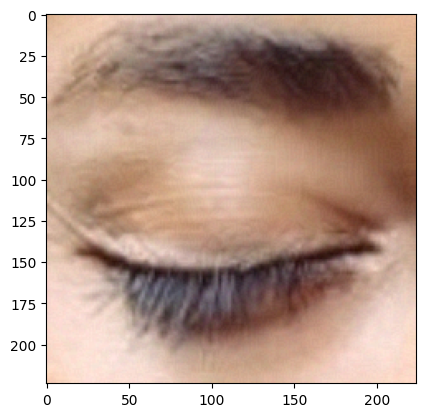

In [ ]:
plt.imshow(adv_examples_fgsm[2])

In [ ]:
# Calculate 25% of training data size
num_samples_25_percent = int(len(X_train) * 0.25)
default_batch_size = 32
# Adjust num_samples to be a multiple of the batch size
num_samples_25_percent = num_samples_25_percent - (num_samples_25_percent % default_batch_size)

print(num_samples_25_percent)
print(X_test.shape)

224
(436, 224, 224, 3)


In [ ]:
def retrain_model_with_fgsm(model, X_train, y_train, train_generator, test_generator, epsilon=0.01, retrain_epochs=10, num_samples=None):
    # Generate FGSM adversarial examples for training
    adv_examples_fgsm_train, adv_labels_fgsm_train = fgsm_attack_with_generator(model, train_generator, epsilon, num_samples=num_samples)

    # Mix adversarial examples with original training data
    X_train_mixed, y_train_mixed = mix_data_with_adversarial_examples(X_train, y_train, adv_examples_fgsm_train, adv_labels_fgsm_train)
    train_generator_mixed = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, rotation_range=30).flow(X_train_mixed, y_train_mixed, shuffle=True)

    print('Now Retraining')
    # Clone, compile, and retrain the model
    cloned_model_fgsm = tf.keras.models.clone_model(model)
    cloned_model_fgsm.set_weights(model.get_weights())

    cloned_model_fgsm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cloned_model_fgsm.fit(train_generator_mixed, epochs=retrain_epochs)

    # Evaluate the retrained model on clean test data
    loss_clean, accuracy_clean = cloned_model_fgsm.evaluate(test_generator)
    print(f"FGSM Retrained Model (Clean Data) - Loss: {loss_clean}, Accuracy: {accuracy_clean}")


    ## These adversarial samples are generated from the baseline model
    adv_examples_fgsm_test, adv_labels_fgsm_test = fgsm_attack_with_generator(model, test_generator, epsilon)

    loss_adv, accuracy_adv = cloned_model_fgsm.evaluate(adv_examples_fgsm_test, adv_labels_fgsm_test)
    print(f"FGSM Retrained Model (Adversarial Data) - Loss: {loss_adv}, Accuracy: {accuracy_adv}")

    # Save the retrained model
    cloned_model_fgsm.save('/content/drive/MyDrive/MLCS_Project_SavedModels/driver_drowsiness_mobilenet_imagenet_fgsm_retrained_eyes_open_closed.keras')

    return cloned_model_fgsm



# Usage example
retrained_model_fgsm = retrain_model_with_fgsm(model, X_train, y_train, train_generator, test_generator, retrain_epochs=10, num_samples=num_samples_25_percent)

number of samples=224
Now Retraining
Epoch 1/10
39/39 [==============================] - 25s 297ms/step - loss: 0.6529 - accuracy: 0.6774
Epoch 2/10
39/39 [==============================] - 12s 309ms/step - loss: 0.3616 - accuracy: 0.8435
Epoch 3/10
39/39 [==============================] - 12s 306ms/step - loss: 0.2596 - accuracy: 0.8960
Epoch 4/10
39/39 [==============================] - 12s 308ms/step - loss: 0.2040 - accuracy: 0.9331
Epoch 5/10
39/39 [==============================] - 12s 309ms/step - loss: 0.1734 - accuracy: 0.9339
Epoch 6/10
39/39 [==============================] - 12s 309ms/step - loss: 0.1428 - accuracy: 0.9468
Epoch 7/10
39/39 [==============================] - 13s 321ms/step - loss: 0.0737 - accuracy: 0.9766
Epoch 8/10
39/39 [==============================] - 12s 311ms/step - loss: 0.0662 - accuracy: 0.9750
Epoch 9/10
39/39 [==============================] - 12s 312ms/step - loss: 0.0624 - accuracy: 0.9798
Epoch 10/10
14/14 [==============================] - 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
retrained_model_fgsm.save('/content/drive/MyDrive/MLCS_Project_SavedModels/driver_drowsiness_mobilenet_imagenet_fgsm_retrained_eyes_open_closed.keras')

#PGD Attack

In [ ]:
import tensorflow as tf

def pgd_attack_with_generator(model, data_generator ,epsilon=0.01, num_steps=40, step_size=0.01, num_samples=None):
    print(f'number of samples={num_samples}')
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    adv_images_list = []
    true_labels_list = []

    dataset_size = len(data_generator)*data_generator.batch_size

    images_list = []
    total_samples_processed = 0
    for images, labels in data_generator:
        adv_images = tf.convert_to_tensor(images, dtype=tf.float32)
        for step in range(num_steps):
            with tf.GradientTape() as tape:
                tape.watch(adv_images)
                prediction = model(adv_images)
                loss = loss_object(labels, prediction)

            gradient = tape.gradient(loss, adv_images)
            signed_grad = tf.sign(gradient)
            adv_images = adv_images + step_size * signed_grad
            adv_images = tf.clip_by_value(adv_images, images - epsilon, images + epsilon)
            adv_images = tf.clip_by_value(adv_images, 0, 1)

        adv_images_list.append(adv_images)
        true_labels_list.append(labels)

        images_list.append(images)

        # Increment the total samples processed
        total_samples_processed += adv_images.shape[0]

        # Check if all samples have been processed
        if num_samples is None and total_samples_processed >= dataset_size:
            break

        if num_samples is not None and len(adv_images_list) * data_generator.batch_size >= num_samples:
            break

    adv_examples = tf.concat(adv_images_list, axis=0)
    true_labels = tf.concat(true_labels_list, axis=0)
    print('Reached Here')

    if num_samples is not None:
        return adv_examples[:num_samples], true_labels[:num_samples]
    else:
        print('Reached Here1')
        return adv_examples, true_labels


In [ ]:
# Use the test_generator to generate the data
num_samples_25_percent = int(len(X_train) * 0.25)  # Adjust based on the number of samples you need
adv_examples_pgd, true_labels_pgd, true_images = pgd_attack_with_generator(model, test_generator, epsilon=0.01, num_samples = num_samples_25_percent)

# Evaluate the model on adversarial examples
loss, accuracy = model.evaluate(adv_examples_pgd, true_labels_pgd, verbose=2)
print(f"Loss on adversarial examples: {loss}")
print(f"Accuracy on adversarial examples: {accuracy}")

number of samples=254
Reached Here
8/8 - 0s - loss: 46.6596 - accuracy: 0.0000e+00 - 161ms/epoch - 20ms/step
Loss on adversarial examples: 46.65964889526367
Accuracy on adversarial examples: 0.0


In [ ]:
def mix_data_with_adversarial_examples(X_train, y_train, adv_examples, adv_labels):
    X_mixed = np.concatenate([X_train, adv_examples], axis=0)
    y_mixed = np.concatenate([y_train, adv_labels], axis=0)
    return X_mixed, y_mixed

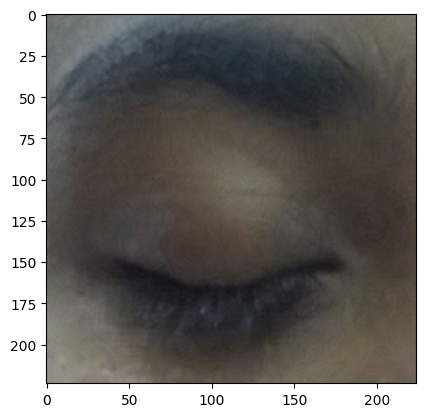

In [ ]:
plt.imshow(adv_examples_pgd[1])

In [ ]:
np.not_equal(adv_examples_pgd[1], true_images[1]).sum()

103738

In [ ]:
# Calculate 25% of training data size
num_samples_25_percent = int(len(X_train) * 0.25)
default_batch_size = 32
# Adjust num_samples to be a multiple of the batch size
num_samples_25_percent = num_samples_25_percent - (num_samples_25_percent % default_batch_size)
print(num_samples_25_percent)
print(X_test.shape)

224
(436, 224, 224, 3)


In [ ]:
def retrain_model_with_pgd(model, X_train, y_train, test_generator, epsilon=0.01, num_steps=40, step_size=0.01, retrain_epochs=10, num_samples_for_evaluation=None):
    # Generate PGD adversarial examples for part of the training dataset(25%)
    adv_examples_pgd_train, adv_labels_pgd_train = pgd_attack_with_generator(model, train_generator,epsilon, num_steps, step_size, num_samples=num_samples_for_evaluation)

    # Mix adversarial examples with original training data
    X_train_mixed, y_train_mixed = mix_data_with_adversarial_examples(X_train, y_train, adv_examples_pgd_train, adv_labels_pgd_train)
    train_generator_mixed = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, rotation_range=30).flow(X_train_mixed, y_train_mixed, shuffle=True)

    # Clone, compile, and retrain the model
    cloned_model_pgd = tf.keras.models.clone_model(model)
    cloned_model_pgd.set_weights(model.get_weights())
    cloned_model_pgd.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cloned_model_pgd.fit(train_generator_mixed, epochs=retrain_epochs)

    # Evaluate the retrained model on clean test data
    loss_clean, accuracy_clean = cloned_model_pgd.evaluate(test_generator)
    print(f"PGD Retrained Model (Clean Data) - Loss: {loss_clean}, Accuracy: {accuracy_clean}")

    # Evaluate on adversarial test data generated from the original baseline model
    #  | NOT PASSING NUM_SAMPLES_FOR_EVALUATION | using default epsilon,nums_steps and step_size
    adv_examples_pgd_test, adv_labels_pgd_test = pgd_attack_with_generator(model, test_generator, epsilon, num_steps, step_size)
    loss_adv, accuracy_adv = cloned_model_pgd.evaluate(adv_examples_pgd_test, adv_labels_pgd_test)
    print(f"PGD Retrained Model (Adversarial Data) - Loss: {loss_adv}, Accuracy: {accuracy_adv}")

    # Save the retrained model
    cloned_model_pgd.save('/content/drive/MyDrive/MLCS_Project_SavedModels/driver_drowsiness_mobilenet_imagenet_pgd_retrained_eyes_open_closed.keras')

    return cloned_model_pgd


# Usage example
retrained_model_pgd = retrain_model_with_pgd(model, np.array(X_train), y_train, test_generator,retrain_epochs=10, num_samples_for_evaluation= num_samples_25_percent)  # Specify the number of epochs


number of samples=224
Reached Here
Epoch 1/10
39/39 [==============================] - 27s 313ms/step - loss: 0.0350 - accuracy: 0.9879
Epoch 2/10
39/39 [==============================] - 13s 327ms/step - loss: 0.0342 - accuracy: 0.9919
Epoch 3/10
39/39 [==============================] - 13s 335ms/step - loss: 0.0292 - accuracy: 0.9911
Epoch 4/10
39/39 [==============================] - 13s 334ms/step - loss: 0.0154 - accuracy: 0.9944
Epoch 5/10
39/39 [==============================] - 13s 326ms/step - loss: 0.0383 - accuracy: 0.9887
Epoch 6/10
39/39 [==============================] - 13s 328ms/step - loss: 0.0091 - accuracy: 0.9976
Epoch 7/10
39/39 [==============================] - 13s 328ms/step - loss: 0.0524 - accuracy: 0.9855
Epoch 8/10
39/39 [==============================] - 13s 326ms/step - loss: 0.0873 - accuracy: 0.9831
Epoch 9/10
39/39 [==============================] - 13s 333ms/step - loss: 0.0233 - accuracy: 0.9944
Epoch 10/10
14/14 [==============================] - 1s 

In [ ]:
retrained_model_pgd.save('/content/drive/MyDrive/MLCS_Project_SavedModels/driver_drowsiness_mobilenet_imagenet_pgd_retrained_eyes_open_closed.keras')

# AutoPGD

In [ ]:
import tensorflow as tf
import numpy as np

def autopgd_attack_with_generator(model, data_generator, epsilon=1.0, num_steps=40, num_samples=None, step_adaptation=1.5):
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    adv_images_list = []
    true_labels_list = []
    dataset_size = len(data_generator) * data_generator.batch_size

    total_samples_processed = 0
    for images, labels in data_generator:
        adv_images = tf.convert_to_tensor(images, dtype=tf.float32)
        delta = tf.zeros_like(adv_images)
        step_size = epsilon / num_steps  # Initial step size

        for step in range(num_steps):
            with tf.GradientTape() as tape:
                tape.watch(delta)
                prediction = model(adv_images + delta)
                loss = loss_object(labels, prediction)

            gradient = tape.gradient(loss, delta)
            gradient_norm = tf.norm(tf.reshape(gradient, (gradient.shape[0], -1)), axis=1)
            gradient_unit = gradient / (gradient_norm[:, None, None, None] + 1e-8)

            # Update step with adaptive step size
            step_size *= step_adaptation if step % 10 == 0 else 1.0

            delta += step_size * tf.sign(gradient_unit)
            delta = tf.clip_by_value(delta, -epsilon, epsilon)
            perturbed_images = adv_images + delta
            perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)

        adv_images_list.append(perturbed_images)
        true_labels_list.append(labels)

        total_samples_processed += adv_images.shape[0]
        if num_samples is None and total_samples_processed >= dataset_size:
            break
        if num_samples is not None and len(adv_images_list) * data_generator.batch_size >= num_samples:
            break

    adv_examples = tf.concat(adv_images_list, axis=0)
    true_labels = tf.concat(true_labels_list, axis=0)

    if num_samples is not None:
        return adv_examples[:num_samples], true_labels[:num_samples]
    else:
        return adv_examples, true_labels

In [ ]:
# Example usage
num_samples = 256  # Adjust as needed
adv_examples_autopgd, true_labels_autopgd = autopgd_attack_with_generator(model, test_generator, epsilon=0.01, num_samples=num_samples)

# Evaluate the model on adversarial examples generated by the AutoPGD attack
loss_autopgd, accuracy_autopgd = model.evaluate(adv_examples_autopgd, true_labels_autopgd, verbose=2)
print(f"Loss on AutoPGD adversarial examples: {loss_autopgd}")
print(f"Accuracy on AutoPGD adversarial examples: {accuracy_autopgd}")

8/8 - 0s - loss: 65.1005 - accuracy: 0.0000e+00 - 164ms/epoch - 20ms/step
Loss on AutoPGD adversarial examples: 65.10047149658203
Accuracy on AutoPGD adversarial examples: 0.0


In [ ]:
def mix_data_with_adversarial_examples(X_train, y_train, adv_examples, adv_labels):
    X_mixed = np.concatenate([X_train, adv_examples], axis=0)
    y_mixed = np.concatenate([y_train, adv_labels], axis=0)
    return X_mixed, y_mixed

In [ ]:
# Calculate 25% of training data size
num_samples_25_percent = int(len(X_train) * 0.25)
default_batch_size = 32
# Adjust num_samples to be a multiple of the batch size
num_samples_25_percent = num_samples_25_percent - (num_samples_25_percent % default_batch_size)
print(num_samples_25_percent)

224


In [ ]:
# Assuming the autopgd_attack_with_generator function is defined as provided earlier

def retrain_model_with_autopgd(model, X_train, y_train, test_generator, epsilon=1.0, num_steps=40, retrain_epochs=10, num_samples_for_evaluation=None):
    # Generate AutoPGD adversarial examples for part of the training dataset (e.g., 25%)
    adv_examples_autopgd_train, adv_labels_autopgd_train = autopgd_attack_with_generator(model, train_generator, epsilon, num_steps, num_samples=num_samples_for_evaluation)

    # Mix adversarial examples with original training data
    X_train_mixed, y_train_mixed = mix_data_with_adversarial_examples(X_train, y_train, adv_examples_autopgd_train, adv_labels_autopgd_train)
    train_generator_mixed = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, rotation_range=30).flow(X_train_mixed, y_train_mixed, shuffle=True)

    # Clone, compile, and retrain the model
    cloned_model_autopgd = tf.keras.models.clone_model(model)
    cloned_model_autopgd.set_weights(model.get_weights())
    cloned_model_autopgd.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    cloned_model_autopgd.fit(train_generator_mixed, epochs=retrain_epochs)

    # Evaluate the retrained model on clean test data
    loss_clean, accuracy_clean = cloned_model_autopgd.evaluate(test_generator)
    print(f"AutoPGD Retrained Model (Clean Data) - Loss: {loss_clean}, Accuracy: {accuracy_clean}")

    # Evaluate on adversarial test data generated from the original baseline model
    adv_examples_autopgd_test, adv_labels_autopgd_test = autopgd_attack_with_generator(model, test_generator, epsilon, num_steps)
    loss_adv, accuracy_adv = cloned_model_autopgd.evaluate(adv_examples_autopgd_test, adv_labels_autopgd_test)
    print(f"AutoPGD Retrained Model (Adversarial Data) - Loss: {loss_adv}, Accuracy: {accuracy_adv}")

    # Save the retrained model
    cloned_model_autopgd.save('/content/drive/MyDrive/MLCS_Project_SavedModels/driver_drowsiness_mobilenet_imagenet_autopgd_retrained_eyes_open_closed.keras')

    return cloned_model_autopgd

# Example usage:
# Prepare or load your original model, training data (X_train, y_train), and test_generator
# Retrain the model with AutoPGD
retrained_model_autopgd = retrain_model_with_autopgd(model, np.array(X_train), y_train, test_generator, retrain_epochs=10, num_samples_for_evaluation=num_samples_25_percent)


Epoch 1/10
39/39 [==============================] - 23s 305ms/step - loss: 0.1831 - accuracy: 0.8976
Epoch 2/10
39/39 [==============================] - 12s 317ms/step - loss: 0.1364 - accuracy: 0.9532
Epoch 3/10
39/39 [==============================] - 12s 313ms/step - loss: 0.0863 - accuracy: 0.9774
Epoch 4/10
39/39 [==============================] - 13s 322ms/step - loss: 0.0840 - accuracy: 0.9758
Epoch 5/10
39/39 [==============================] - 13s 320ms/step - loss: 0.0391 - accuracy: 0.9863
Epoch 6/10
39/39 [==============================] - 13s 320ms/step - loss: 0.0486 - accuracy: 0.9847
Epoch 7/10
39/39 [==============================] - 12s 317ms/step - loss: 0.0188 - accuracy: 0.9976
Epoch 8/10
39/39 [==============================] - 12s 317ms/step - loss: 0.0516 - accuracy: 0.9798
Epoch 9/10
39/39 [==============================] - 13s 321ms/step - loss: 0.0136 - accuracy: 0.9944
Epoch 10/10
14/14 [==============================] - 1s 20ms/step - loss: 3.6641e-05 - accu

# DDN Attack

In [ ]:
import tensorflow as tf

def ddn_attack_with_generator(model, data_generator, epsilon=0.01, num_steps=40, num_samples=None):
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    adv_images_list = []
    true_labels_list = []
    dataset_size = len(data_generator)*data_generator.batch_size

    total_samples_processed = 0
    for images, labels in data_generator:
        adv_images = tf.convert_to_tensor(images, dtype=tf.float32)
        delta = tf.zeros_like(adv_images)
        for step in range(num_steps):
            with tf.GradientTape() as tape:
                tape.watch(delta)
                prediction = model(adv_images + delta)
                loss = loss_object(labels, prediction)

            gradient = tape.gradient(loss, delta)
            gradient_norm = tf.norm(tf.reshape(gradient, (gradient.shape[0], -1)), axis=1)
            gradient_unit = gradient / (gradient_norm[:, None, None, None] + 1e-8)

            delta += epsilon / num_steps * gradient_unit
            delta = tf.clip_by_value(delta, -epsilon, epsilon)
            perturbed_images = adv_images + delta
            perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)

        adv_images_list.append(perturbed_images)
        true_labels_list.append(labels)

        total_samples_processed += adv_images.shape[0]
        if num_samples is None and total_samples_processed >= dataset_size:
            break
        if num_samples is not None and len(adv_images_list) * data_generator.batch_size >= num_samples:
            break

    adv_examples = tf.concat(adv_images_list, axis=0)
    true_labels = tf.concat(true_labels_list, axis=0)

    return adv_examples[:num_samples] if num_samples is not None else adv_examples, true_labels



In [ ]:
# Use the test_generator to generate the data for the DDN attack
num_samples = 256  # Adjust based on the number of samples you need
adv_examples_ddn, true_labels_ddn = ddn_attack_with_generator(model, test_generator, epsilon=0.3, num_samples=num_samples)

# Evaluate the model on adversarial examples generated by the DDN attack
loss_ddn, accuracy_ddn = model.evaluate(adv_examples_ddn, true_labels_ddn, verbose=2)
print(f"Loss on DDN adversarial examples: {loss_ddn}")
print(f"Accuracy on DDN adversarial examples: {accuracy_ddn}")


8/8 - 0s - loss: 2.2567 - accuracy: 0.8242 - 165ms/epoch - 21ms/step
Loss on DDN adversarial examples: 2.256739854812622
Accuracy on DDN adversarial examples: 0.82421875


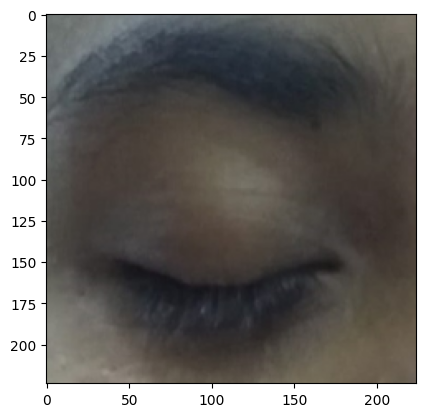

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(adv_examples_ddn[1])

In [ ]:
def mix_data_with_adversarial_examples(X_train, y_train, adv_examples, adv_labels):
    X_mixed = np.concatenate([X_train, adv_examples], axis=0)
    y_mixed = np.concatenate([y_train, adv_labels], axis=0)
    return X_mixed, y_mixed

In [ ]:
# Calculate 25% of training data size
num_samples_25_percent = int(len(X_train) * 0.25)
default_batch_size = 32
# Adjust num_samples to be a multiple of the batch size
num_samples_25_percent = num_samples_25_percent - (num_samples_25_percent % default_batch_size)
print(num_samples_25_percent)


224


In [ ]:
# Calculate 10% of training data size
num_samples_10_percent = int(len(X_train) * 0.10)
default_batch_size = 32
# Adjust num_samples to be a multiple of the batch size
num_samples_10_percent = num_samples_10_percent - (num_samples_10_percent % default_batch_size)
print(num_samples_10_percent)


96


In [ ]:
def retrain_model_with_ddn(model, X_train, y_train, test_generator, epsilon=0.3, num_steps=40, retrain_epochs=10, num_samples_for_evaluation=None):
    # Generate DDN adversarial examples for part of the training dataset (25%)
    adv_examples_ddn_train, adv_labels_ddn_train = ddn_attack_with_generator(model, train_generator, epsilon, num_steps, num_samples=num_samples_for_evaluation)

    # Mix adversarial examples with original training data
    X_train_mixed, y_train_mixed = mix_data_with_adversarial_examples(X_train, y_train, adv_examples_ddn_train, adv_labels_ddn_train)
    train_generator_mixed = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, rotation_range=30).flow(X_train_mixed, y_train_mixed, shuffle=True)

    # Clone, compile, and retrain the model
    cloned_model_ddn = tf.keras.models.clone_model(model)
    cloned_model_ddn.set_weights(model.get_weights())
    cloned_model_ddn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cloned_model_ddn.fit(train_generator_mixed, epochs=retrain_epochs)

    # Evaluate the retrained model on clean test data
    loss_clean, accuracy_clean = cloned_model_ddn.evaluate(test_generator)
    print(f"DDN Retrained Model (Clean Data) - Loss: {loss_clean}, Accuracy: {accuracy_clean}")

    # Evaluate on adversarial test data generated from the original baseline model
    adv_examples_ddn_test, adv_labels_ddn_test = ddn_attack_with_generator(model, test_generator, epsilon, num_steps)
    loss_adv, accuracy_adv = cloned_model_ddn.evaluate(adv_examples_ddn_test, adv_labels_ddn_test)
    print(f"DDN Retrained Model (Adversarial Data) - Loss: {loss_adv}, Accuracy: {accuracy_adv}")

    # Save the retrained model
    cloned_model_ddn.save('/content/drive/MyDrive/MLCS_Project_SavedModels/driver_drowsiness_mobilenet_imagenet_ddn_retrained_eyes_open_closed.keras')

    return cloned_model_ddn

# Usage example
retrained_model_ddn = retrain_model_with_ddn(model, np.array(X_train), y_train, test_generator, retrain_epochs=10, num_samples_for_evaluation=num_samples_25_percent)


Epoch 1/10
39/39 [==============================] - 27s 315ms/step - loss: 0.0633 - accuracy: 0.9879
Epoch 2/10
39/39 [==============================] - 13s 328ms/step - loss: 0.0184 - accuracy: 0.9976
Epoch 3/10
39/39 [==============================] - 13s 326ms/step - loss: 0.0173 - accuracy: 0.9952
Epoch 4/10
39/39 [==============================] - 13s 321ms/step - loss: 0.0581 - accuracy: 0.9887
Epoch 5/10
39/39 [==============================] - 13s 321ms/step - loss: 0.0481 - accuracy: 0.9863
Epoch 6/10
39/39 [==============================] - 13s 326ms/step - loss: 0.0423 - accuracy: 0.9871
Epoch 7/10
39/39 [==============================] - 13s 322ms/step - loss: 0.0211 - accuracy: 0.9935
Epoch 8/10
39/39 [==============================] - 13s 323ms/step - loss: 0.0265 - accuracy: 0.9935
Epoch 9/10
39/39 [==============================] - 13s 326ms/step - loss: 0.0215 - accuracy: 0.9944
Epoch 10/10
14/14 [==============================] - 1s 22ms/step - loss: 1.6062e-05 - accu

In [ ]:
retrained_model_ddn.save('/content/drive/MyDrive/MLCS_Project_SavedModels/driver_drowsiness_mobilenet_imagenet_ddn_retrained_eyes_open_closed.keras')

# DeepFool Attack

In [ ]:
from art.attacks.evasion import DeepFool
from art.estimators.classification import TensorFlowV2Classifier
import tensorflow as tf

In [ ]:
# Deepfool attack works on the logits instead of softmax probabilities,
# therefore we have to make our activation layer linear to have the same effect

# Load pre-trained model with softmax
num_classes = 2

# Create a new model identical to the original up to the layer before softmax
model_without_softmax = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

# Add a new layer with linear activation
linear_layer = tf.keras.layers.Dense(units=num_classes, activation='linear', name='linear_output')(model_without_softmax.output)

# Create a new model with the added linear layer
model_without_softmax = tf.keras.Model(inputs=model_without_softmax.input, outputs=linear_layer)

# Manually copy weights from the softmax layer to the new linear layer
model_without_softmax.layers[-1].set_weights(model.layers[-1].get_weights())

# Compile the new model
model_without_softmax.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
def deepfool_attack_with_generator(model, data_generator, batch_size=32, max_iter=100, num_samples=None):
    classifier = TensorFlowV2Classifier(
                    model=model,
                    clip_values=(0.0, 1.0),
                    optimizer='adam',
                    input_shape=(224,224, 3),
                    nb_classes=2,
    )

    adv_crafter = DeepFool(classifier, batch_size=batch_size)

    adv_images_list = []
    true_labels_list = []

    dataset_size = len(data_generator)*data_generator.batch_size

    total_samples_processed = 0


    for i, batch in enumerate(data_generator):
        if i >=len(train_generator):
            break

        images, labels = batch
        adv_images_list.append(adv_crafter.generate(images, max_iter=max_iter))
        true_labels_list.append(labels)

        # Check if all samples have been processed
        if num_samples is None and len(adv_images_list) * data_generator.batch_size >= dataset_size:
            break

        if num_samples is not None and len(adv_images_list) * data_generator.batch_size >= num_samples:
            break

    adv_examples = tf.concat(adv_images_list, axis=0)
    true_labels = tf.concat(true_labels_list, axis=0)

    if num_samples is not None:
        return adv_examples[:num_samples], true_labels[:num_samples]
    else:
        return adv_examples, true_labels

In [ ]:
adv_examples, true_labels = deepfool_attack_with_generator(model_without_softmax, test_generator, max_iter=100, num_samples=num_samples_25_percent)

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

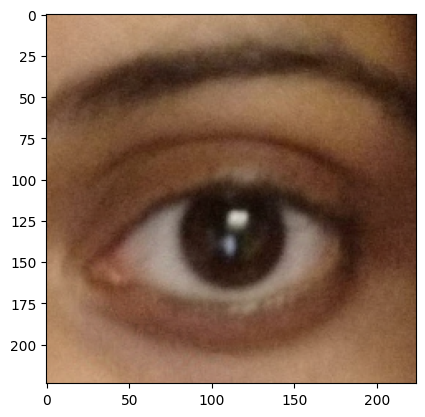

In [ ]:
plt.imshow(adv_examples[0])

In [ ]:
# Evaluate the model on adversarial examples
loss, accuracy = model.evaluate(adv_examples, true_labels, verbose=2)
print(f"Loss on adversarial examples: {loss}")
print(f"Accuracy on adversarial examples: {accuracy}")

8/8 - 0s - loss: 0.8018 - accuracy: 0.4467 - 169ms/epoch - 21ms/step
Loss on adversarial examples: 0.801781952381134
Accuracy on adversarial examples: 0.44672131538391113


In [ ]:
def retrain_model_with_deepfool(model, model_without_softmax, X_train, y_train, test_generator, max_iter=100, retrain_epochs=10, num_samples_for_evaluation=None):

    #generate adversarial images by the deepfool attack
    adv_examples, true_labels = deepfool_attack_with_generator(model_without_softmax, train_generator, max_iter=100, num_samples=num_samples_for_evaluation)

    # Mix adversarial examples with original training data
    X_train_mixed, y_train_mixed = mix_data_with_adversarial_examples(X_train, y_train, adv_examples, true_labels)
    train_generator_mixed = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, rotation_range=30).flow(X_train_mixed, y_train_mixed, shuffle=True)

    print('Now Retraining')
    # Clone, compile, and retrain the model
    cloned_model_df = tf.keras.models.clone_model(model)
    cloned_model_df.set_weights(model.get_weights())
    cloned_model_df.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cloned_model_df.fit(train_generator_mixed, epochs=10)

    # Evaluate the retrained model on clean test data
    loss_clean, accuracy_clean = cloned_model_df.evaluate(test_generator)
    print(f"DeepFool Retrained Model (Clean Data) - Loss: {loss_clean}, Accuracy: {accuracy_clean}")


    # These adversarial samples are generated from the baseline model
    adv_examples_df_test, adv_labels_df_test = deepfool_attack_with_generator(model_without_softmax, test_generator, max_iter=100, num_samples=256)

    #evaluate mode on test dataset
    loss_adv, accuracy_adv = cloned_model_df.evaluate(adv_examples_df_test, adv_labels_df_test)
    print(f"DeepFool Retrained Model (Adversarial Data) - Loss: {loss_adv}, Accuracy: {accuracy_adv}")

    # Save the retrained model
    cloned_model_df.save('/content/drive/MyDrive/MLCS_Project_SavedModels/driver_drowsiness_mobilenet_imagenet_deepfool_retrained_eyes_open_closed.keras')

    return cloned_model_df

cloned_model_df = retrain_model_with_deepfool(model, model_without_softmax, X_train, y_train, test_generator, max_iter=100, retrain_epochs=10, num_samples_for_evaluation=num_samples_25_percent)

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Now Retraining
Epoch 1/10
40/40 [==============================] - 23s 303ms/step - loss: 0.0654 - accuracy: 0.9858
Epoch 2/10
40/40 [==============================] - 13s 319ms/step - loss: 0.0212 - accuracy: 0.9937
Epoch 3/10
40/40 [==============================] - 13s 315ms/step - loss: 0.0160 - accuracy: 0.9984
Epoch 4/10
40/40 [==============================] - 13s 317ms/step - loss: 0.0119 - accuracy: 0.9984
Epoch 5/10
40/40 [==============================] - 13s 321ms/step - loss: 0.0215 - accuracy: 0.9937
Epoch 6/10
40/40 [==============================] - 13s 317ms/step - loss: 0.0067 - accuracy: 0.9961
Epoch 7/10
40/40 [==============================] - 13s 325ms/step - loss: 0.0015 - accuracy: 0.9992
Epoch 8/10
40/40 [==============================] - 13s 321ms/step - loss: 0.0548 - accuracy: 0.9937
Epoch 9/10
40/40 [==============================] - 13s 317ms/step - loss: 0.0276 - accuracy: 0.9913
Epoch 10/10
14/14 [==============================] - 1s 23ms/step - loss: 0.

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

8/8 [==============================] - 0s 19ms/step - loss: 1.4938e-04 - accuracy: 1.0000
DeepFool Retrained Model (Adversarial Data) - Loss: 0.0001493813906563446, Accuracy: 1.0


# Targeted Patch Attack

We generate adversary patch that will fool the model to detect Open eyes as Closed which would be a threat for drowsy driver.

In [ ]:
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import AdversarialPatch

In [ ]:
def get_adversarial_patch_obj(model, mean_values, batch_size=32):

    # Define TensorFlowV2Classifier with the new preprocessor
    tfc = TensorFlowV2Classifier(model=model, loss_object=None, train_step=None, nb_classes=2, input_shape=(224, 224, 3), clip_values=(0, 1),
                                preprocessing=(mean_values, np.array([1.0, 1.0, 1.0])))

    ap = AdversarialPatch(classifier=tfc, rotation_max=22.5, scale_min=0.4, scale_max=1.0,
                        learning_rate=5000., max_iter=100, batch_size=batch_size,  patch_shape=(224, 224, 3))

    return ap

In [ ]:
# Import the necessary preprocessing module from ART
def patch_attack_with_generator(model, data_generator, batch_size=32, num_samples=None):

    #array to store images
    images_list = np.array([])

    #get the dataset from the generator
    for i, batch in enumerate(data_generator):
        if i >=len(data_generator):
            break

        images = batch[0]

        #if first image batch, add new image as its
        if len(images_list) == 0 :
            images_list = np.concatenate([images])

        else:
            #else, append teh data to the existing image data
            if len(images_list) <= num_samples:
                images_list = np.concatenate([images_list, images])

            else:
                break

    #one hot encoding to generate patch for Closed images
    y_one_hot = np.zeros(2)

    y_one_hot[0] = 1 #target label is closed

    #repeat for all the samples in generator
    y_target = np.tile(y_one_hot, (images_list.shape[0], 1))

    mean_values = np.mean(X_train, axis=(0, 1, 2))
    # std_values = np.std(X_train, axis=(0, 1, 2))

    #create patch object
    ap = get_adversarial_patch_obj(model, mean_values, batch_size=batch_size)

    #generate adversary patch and patch mask
    patch, patch_mask = ap.generate(x=images_list, y=y_target)

    return patch, patch_mask, mean_values

In [ ]:
patch, patch_mask, mean_values = patch_attack_with_generator(model, train_generator, batch_size=64, num_samples=10)

Adversarial Patch TensorFlow v2:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import pickle

# Assuming 'patch' and 'patch_mask' are your generated patch and patch mask
# You can save them to a file like this:

with open('/content/drive/MyDrive/MLCS_Project_SavedModels/Data/Patch/patch_data_new.pkl', 'wb') as file:
    data = {'patch': patch, 'patch_mask': patch_mask, 'mean_values': mean_values}
    pickle.dump(data, file)

In [ ]:
import pickle
import matplotlib.pyplot as plt

with open('/content/drive/MyDrive/MLCS_Project_SavedModels/Data/Patch/patch_data_new.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
    patch = loaded_data['patch']
    patch_mask = loaded_data['patch_mask']
    mean_values = loaded_data['mean_values']
    # std_values = loaded_data['std_values']

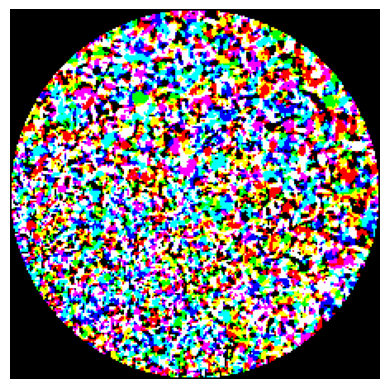

In [ ]:
plt.imshow(patch*patch_mask)
plt.axis("off")
plt.show()

In [ ]:
mean_values = np.mean(X_train, axis=(0, 1, 2))
ap = get_adversarial_patch_obj(model, mean_values)

In [ ]:
test_patched_images = ap.apply_patch(X_test[:2], scale=0.3, patch_external=patch*patch_mask, mask=np.expand_dims(patch_mask.astype(np.bool_)[:, :, 0], axis=0))

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


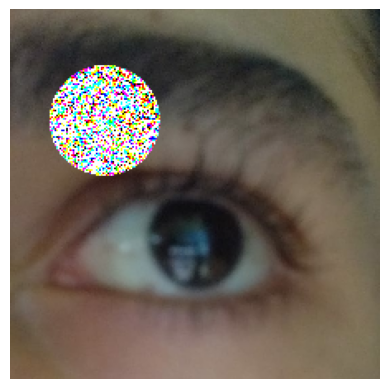

In [ ]:
plt.imshow(test_patched_images[1])
plt.axis("off")
plt.show()

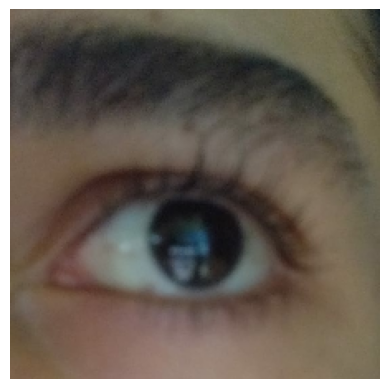

In [ ]:
plt.imshow(X_test[1])
plt.axis("off")
plt.show()

In [ ]:
# Evaluate the model on adversarial examples generated by the AutoPGD attack
loss_patch, accuracy_patch = model.evaluate(test_patched_images, y_test[:100], verbose=2)
print(f"Loss on Patch Attack adversarial examples: {loss_patch}")
print(f"Accuracy on Patch Attack adversarial examples: {accuracy_patch}")

4/4 - 0s - loss: 4.7433 - accuracy: 0.5400 - 90ms/epoch - 23ms/step
Loss on Patch Attack adversarial examples: 4.743316650390625
Accuracy on Patch Attack adversarial examples: 0.5400000214576721


In [ ]:
def retrain_model_with_patch(model, X_train, y_train, patch, patch_mask, mean_values, test_generator, retrain_epochs=10, num_samples=None):

    ap = get_adversarial_patch_obj(model, mean_values)
    adv_images = ap.apply_patch(X_train[:num_samples], scale=0.2 ,patch_external=patch*patch_mask, mask=np.expand_dims(patch_mask.astype(np.bool_)[:, :, 0], axis=0))
    X_train_mixed, y_train_mixed = mix_data_with_adversarial_examples(X_train, y_train, adv_images, y_train[:num_samples])
    train_generator_mixed = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, rotation_range=30).flow(X_train_mixed, y_train_mixed, shuffle=True)

    print('Now Retraining')
    # Clone, compile, and retrain the model
    cloned_model_patch = tf.keras.models.clone_model(model)
    cloned_model_patch.set_weights(model.get_weights())
    cloned_model_patch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cloned_model_patch.fit(train_generator_mixed, epochs=10)

    X_test = []
    y_test = []

    for i in range(len(test_generator)):
        images, labels = test_generator.next()
        X_test.extend(images)
        y_test.extend(labels)

    X_test = np.concatenate([X_test])
    y_test = np.concatenate([y_test])

    # Evaluate the retrained model on clean test data
    loss_clean, accuracy_clean = cloned_model_patch.evaluate(X_test, y_test)
    print(f"Patche Attack Retrained Model (Clean Data) - Loss: {loss_clean}, Accuracy: {accuracy_clean}")

    # If you want to evaluate on adversarial test data, generate it here
    # These adversarial samples are generated from the baseline model
    adv_examples_df_test = ap.apply_patch(X_test, scale=0.2 ,patch_external=patch*patch_mask, mask=np.expand_dims(patch_mask.astype(np.bool_)[:, :, 0], axis=0))
    ## Add batch_size here
    loss_adv, accuracy_adv = cloned_model_patch.evaluate(adv_examples_df_test, y_test)
    print(f"Patch Attack Retrained Model (Adversarial Data) - Loss: {loss_adv}, Accuracy: {accuracy_adv}")

    # Save the retrained model
    cloned_model_patch.save('/content/drive/MyDrive/MLCS_Project_SavedModels/driver_drowsiness_mobilenet_imagenet_patched_retrained_eyes_open_closed.keras')

retrained_model_patch = retrain_model_with_patch(model, X_train, y_train, patch, patch_mask, mean_values, test_generator, retrain_epochs=10, num_samples=num_samples_25_percent)


Now Retraining
Epoch 1/10
40/40 [==============================] - 25s 325ms/step - loss: 0.0711 - accuracy: 0.9835
Epoch 2/10
40/40 [==============================] - 13s 325ms/step - loss: 0.0264 - accuracy: 0.9898
Epoch 3/10
40/40 [==============================] - 13s 330ms/step - loss: 0.0234 - accuracy: 0.9913
Epoch 4/10
40/40 [==============================] - 13s 327ms/step - loss: 0.0030 - accuracy: 0.9984
Epoch 5/10
40/40 [==============================] - 13s 330ms/step - loss: 0.0210 - accuracy: 0.9969
Epoch 6/10
40/40 [==============================] - 13s 332ms/step - loss: 0.0413 - accuracy: 0.9866
Epoch 7/10
40/40 [==============================] - 13s 327ms/step - loss: 0.0169 - accuracy: 0.9969
Epoch 8/10
40/40 [==============================] - 13s 330ms/step - loss: 0.0084 - accuracy: 0.9976
Epoch 9/10
40/40 [==============================] - 13s 324ms/step - loss: 0.0319 - accuracy: 0.9898
Epoch 10/10
14/14 [==============================] - 1s 20ms/step - loss: 1.

# Carlini Wagner

In [ ]:
from art.attacks.evasion import CarliniL2Method, CarliniLInfMethod
from art.estimators.classification import TensorFlowV2Classifier

In [ ]:
# Carlini Wagner attack works on the logits instead of softmax probabilities,
# therefore we have to make our activation layer linear to have the same effect

# Load pre-trained model with softmax
num_classes = 2

# Create a new model identical to the original up to the layer before softmax
model_without_softmax = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

# Add a new layer with linear activation
linear_layer = tf.keras.layers.Dense(units=num_classes, activation='linear', name='linear_output')(model_without_softmax.output)

# Create a new model with the added linear layer
model_without_softmax = tf.keras.Model(inputs=model_without_softmax.input, outputs=linear_layer)

# Manually copy weights from the softmax layer to the new linear layer
model_without_softmax.layers[-1].set_weights(model.layers[-1].get_weights())

# Compile the new model
model_without_softmax.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
def cw_attack_with_generator(model,data_generator, batch_size=32, max_iter=10, num_samples=None):
    classifier = TensorFlowV2Classifier(
        model=model,
        clip_values=(0.0, 1.0),
        optimizer='adam',
        input_shape=(224, 224, 3),
        nb_classes=2,
    )

    adv_crafter = CarliniL2Method(classifier, targeted=True, max_iter=max_iter, batch_size=batch_size)

    #array to store images
    images_list = np.array([])
    labels_list = np.array([])
    #get the dataset from the generator
    for i, batch in enumerate(data_generator):
        if i >=len(data_generator):
            break

        images, labels = batch

        #if first image batch, add new image as its
        if len(images_list) == 0 :
            images_list = np.concatenate([images])
            labels_list = np.concatenate([labels])

        else:
            #else, append the data to the existing image data
            if len(images_list) <= num_samples:
                images_list = np.concatenate([images_list, images])
                labels_list = np.concatenate([labels_list, labels])

            else:
                break

    #one hot encoding to generate patch for Closed images
    y_one_hot = np.zeros(2)

    y_one_hot[0] = 1 #target label is closed

    #repeat for all the samples in generator
    y_target = np.tile(y_one_hot, (images_list.shape[0], 1))

    #generate adversary images for the original image and targeted labels
    adv_images = adv_crafter.generate(images_list, y_target)

    return images_list, adv_images, labels_list

In [ ]:
orignal_images, adv_examples, true_labels = cw_attack_with_generator(model_without_softmax, test_generator, max_iter=10, num_samples=256)

C&W L_2:   0%|          | 0/9 [00:00<?, ?it/s]

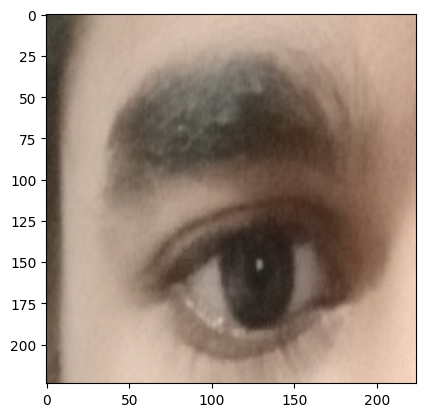

In [ ]:
plt.imshow(orignal_images[0])

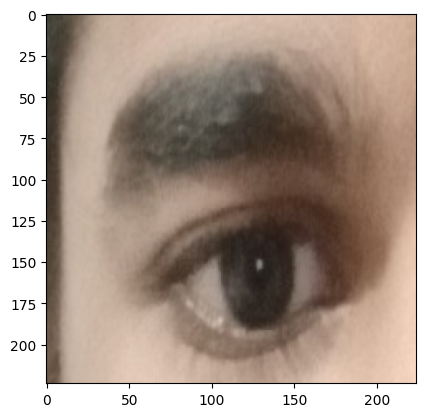

In [ ]:
plt.imshow(adv_examples[0])

In [ ]:
#number of pixels which are same before and after the adversary attack
np.equal(adv_examples[0], orignal_images[0]).sum()

10

In [ ]:
# Evaluate the model on adversarial examples
loss, accuracy = model.evaluate(adv_examples, true_labels, verbose=2)
print(f"Loss on adversarial examples: {loss}")
print(f"Accuracy on adversarial examples: {accuracy}")

9/9 - 0s - loss: 1.5282 - accuracy: 0.5104 - 202ms/epoch - 22ms/step
Loss on adversarial examples: 1.5281896591186523
Accuracy on adversarial examples: 0.5104166865348816


In [ ]:
def mix_data_with_adversarial_examples(X_train, y_train, adv_examples, adv_labels):
    X_mixed = np.concatenate([X_train, adv_examples], axis=0)
    y_mixed = np.concatenate([y_train, adv_labels], axis=0)
    return X_mixed, y_mixed

In [ ]:
# Calculate 25% of training data size
num_samples_25_percent = int(len(X_train) * 0.25)
default_batch_size = 32
# Adjust num_samples to be a multiple of the batch size
num_samples_25_percent = num_samples_25_percent - (num_samples_25_percent % default_batch_size)

print(num_samples_25_percent)
print(X_test.shape)

224
(436, 224, 224, 3)


In [ ]:
def retrain_model_with_cw(model, model_without_softmax, X_train, y_train, train_generator, test_generator, batch_size=32, max_iter=10, retrain_epochs=10, num_samples_for_evaluation=None):

    #generate adversarial images by the Carlini Wagner attack
    original_images, adv_examples, true_labels = cw_attack_with_generator(model_without_softmax, train_generator, batch_size=batch_size, max_iter=max_iter, num_samples=num_samples_for_evaluation)

    # Mix adversarial examples with original training data
    X_train_mixed, y_train_mixed = mix_data_with_adversarial_examples(X_train, y_train, adv_examples, true_labels)
    train_generator_mixed = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, rotation_range=30).flow(X_train_mixed, y_train_mixed, shuffle=True)

    print('Now Retraining')
    # Clone, compile, and retrain the model
    cloned_model_cw = tf.keras.models.clone_model(model)
    cloned_model_cw.set_weights(model.get_weights())
    cloned_model_cw.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cloned_model_cw.fit(train_generator_mixed, epochs=10)

    # Evaluate the retrained model on clean test data
    loss_clean, accuracy_clean = cloned_model_cw.evaluate(test_generator)
    print(f"Carlini Wagner Retrained Model (Clean Data) - Loss: {loss_clean}, Accuracy: {accuracy_clean}")


    # These adversarial samples are generated from the baseline model
    adv_examples_df_test, adv_labels_df_test = adv_examples[:num_samples_for_evaluation], true_labels[:num_samples_for_evaluation]

    #evaluate mode on test dataset
    loss_adv, accuracy_adv = cloned_model_cw.evaluate(adv_examples_df_test, adv_labels_df_test)
    print(f"Carlini Wagner Retrained Model (Adversarial Data) - Loss: {loss_adv}, Accuracy: {accuracy_adv}")

    # Save the retrained model
    cloned_model_cw.save('/content/drive/MyDrive/MLCS_Project_SavedModels/driver_drowsiness_mobilenet_imagenet_carlini_wagner_retrained_eyes_open_closed.keras')

    return cloned_model_cw

retrained_model_cw = retrain_model_with_cw(model, model_without_softmax, X_train, y_train, train_generator, test_generator, batch_size=32, max_iter=10, retrain_epochs=10, num_samples_for_evaluation=num_samples_25_percent)


C&W L_2:   0%|          | 0/8 [00:00<?, ?it/s]

Now Retraining
Epoch 1/10
40/40 [==============================] - 26s 302ms/step - loss: 0.0314 - accuracy: 0.9906
Epoch 2/10
40/40 [==============================] - 13s 311ms/step - loss: 0.0369 - accuracy: 0.9914
Epoch 3/10
40/40 [==============================] - 13s 315ms/step - loss: 0.0163 - accuracy: 0.9961
Epoch 4/10
40/40 [==============================] - 13s 323ms/step - loss: 0.0104 - accuracy: 0.9984
Epoch 5/10
40/40 [==============================] - 13s 316ms/step - loss: 0.0034 - accuracy: 0.9992
Epoch 6/10
40/40 [==============================] - 13s 317ms/step - loss: 0.0292 - accuracy: 0.9929
Epoch 7/10
40/40 [==============================] - 13s 316ms/step - loss: 0.0124 - accuracy: 0.9969
Epoch 8/10
40/40 [==============================] - 13s 318ms/step - loss: 0.0056 - accuracy: 0.9984
Epoch 9/10
40/40 [==============================] - 13s 316ms/step - loss: 0.0242 - accuracy: 0.9921
Epoch 10/10
14/14 [==============================] - 1s 21ms/step - loss: 1.

# Boundary Attack

In [ ]:
from art.attacks.evasion import BoundaryAttack
from art.estimators.classification import TensorFlowV2Classifier

In [ ]:
# Boundary attack works on the logits instead of softmax probabilities,
# therefore we have to make our activation layer linear to have the same effect

# Load pre-trained model with softmax
num_classes = 2

# Create a new model identical to the original up to the layer before softmax
model_without_softmax = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

# Add a new layer with linear activation
linear_layer = tf.keras.layers.Dense(units=num_classes, activation='linear', name='linear_output')(model_without_softmax.output)

# Create a new model with the added linear layer
model_without_softmax = tf.keras.Model(inputs=model_without_softmax.input, outputs=linear_layer)

# Manually copy weights from the softmax layer to the new linear layer
model_without_softmax.layers[-1].set_weights(model.layers[-1].get_weights())

# Compile the new model
model_without_softmax.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Import the necessary preprocessing module from ART
def boundary_attack_with_generator(model, data_generator, epsilon=0.1, batch_size=64, max_iter=100, num_samples=None):

    classifier = TensorFlowV2Classifier(
        model=model,
        clip_values=(0.0, 1.0),
        optimizer='adam',
        input_shape=(224, 224, 3),
        nb_classes=2,
    )

    adv_crafter = BoundaryAttack(classifier, targeted=False, epsilon=epsilon, batch_size=batch_size, max_iter=max_iter)

    #array to store images
    images_list = np.array([])
    labels_list = np.array([])
    #get the dataset from the generator
    for i, batch in enumerate(data_generator):
        if i >=len(data_generator):
            break

        images, labels = batch

        #if first image batch, add new image as its
        if len(images_list) == 0 :
            images_list = np.concatenate([images])
            labels_list = np.concatenate([labels])

        else:
            #else, append teh data to the existing image data
            if len(images_list) <= num_samples:
                images_list = np.concatenate([images_list, images])
                labels_list = np.concatenate([labels_list, labels])

            else:
                break

    #one hot encoding to generate patch for Closed images
    y_one_hot = np.zeros(2)

    y_one_hot[0] = 1 #target label is closed

    #repeat for all the samples in generator
    y_target = np.tile(y_one_hot, (images_list.shape[0], 1))

    #generate adversary patch and patch mask
    adv_images = adv_crafter.generate(images_list, labels_list)

    return adv_images, labels_list

In [ ]:
adv_images, labels_list = boundary_attack_with_generator(model_without_softmax, test_generator, epsilon=0.01, max_iter=100, num_samples=100)

Boundary attack:   0%|          | 0/128 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
## Evaluate the model on adversarial examples
loss, accuracy = model.evaluate(adv_images, labels_list, verbose=2)
print(f"Loss on adversarial examples: {loss}")
print(f"Accuracy on adversarial examples: {accuracy}")

4/4 - 0s - loss: 0.6779 - accuracy: 0.0703 - 96ms/epoch - 24ms/step
Loss on adversarial examples: 0.6778841018676758
Accuracy on adversarial examples: 0.0703125


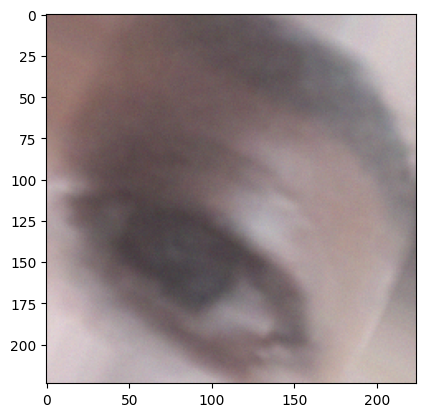

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(adv_images[5])

In [ ]:
def retrain_model_with_boundary(model, model_without_softmax, X_train, y_train, train_generator, test_generator, batch_size=64, epsilon=0.01, max_iter=100, retrain_epochs=10, num_samples_for_evaluation=None):

    #generate adversarial images by the Boundary attack
    adv_examples, true_labels = boundary_attack_with_generator(model_without_softmax, train_generator, batch_size=batch_size, epsilon=epsilon, max_iter=max_iter, num_samples=num_samples_for_evaluation)

    # Mix adversarial examples with original training data
    X_train_mixed, y_train_mixed = mix_data_with_adversarial_examples(X_train, y_train, adv_examples, true_labels)
    train_generator_mixed = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, rotation_range=30).flow(X_train_mixed, y_train_mixed, shuffle=True)

    print('Now Retraining')
    # Clone, compile, and retrain the model
    cloned_model_boundary = tf.keras.models.clone_model(model)
    cloned_model_boundary.set_weights(model.get_weights())
    cloned_model_boundary.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cloned_model_boundary.fit(train_generator_mixed, epochs=10)

    # Evaluate the retrained model on clean test data
    loss_clean, accuracy_clean = cloned_model_boundary.evaluate(test_generator)
    print(f"Boundary Attack Retrained Model (Clean Data) - Loss: {loss_clean}, Accuracy: {accuracy_clean}")


    # These adversarial samples are generated from the baseline model
    adv_examples_df_test, adv_labels_df_test = boundary_attack_with_generator(model_without_softmax, test_generator, batch_size=batch_size, epsilon=epsilon, max_iter=max_iter, num_samples=num_samples_for_evaluation)

    #evaluate mode on test dataset
    loss_adv, accuracy_adv = cloned_model_boundary.evaluate(adv_examples_df_test, adv_labels_df_test)
    print(f"Boundary Attack Retrained Model (Adversarial Data) - Loss: {loss_adv}, Accuracy: {accuracy_adv}")

    # Save the retrained model
    cloned_model_boundary.save('/content/drive/MyDrive/MLCS_Project_SavedModels/driver_drowsiness_mobilenet_imagenet_boundary_retrained_eyes_open_closed.keras')

    return cloned_model_boundary

retrained_model_boundary = retrain_model_with_boundary(model, model_without_softmax, X_train, y_train, train_generator, test_generator, batch_size=64, epsilon=0.01, max_iter=100, retrain_epochs=10, num_samples_for_evaluation=num_samples_25_percent)


Now Retraining
Epoch 1/10
36/36 [==============================] - 21s 291ms/step - loss: 0.0490 - accuracy: 0.9869
Epoch 2/10
36/36 [==============================] - 11s 311ms/step - loss: 0.0302 - accuracy: 0.9913
Epoch 3/10
36/36 [==============================] - 11s 308ms/step - loss: 0.0145 - accuracy: 0.9956
Epoch 4/10
36/36 [==============================] - 11s 308ms/step - loss: 0.0051 - accuracy: 0.9991
Epoch 5/10
36/36 [==============================] - 11s 307ms/step - loss: 0.0075 - accuracy: 0.9974
Epoch 6/10
36/36 [==============================] - 11s 310ms/step - loss: 0.0133 - accuracy: 0.9956
Epoch 7/10
36/36 [==============================] - 11s 310ms/step - loss: 0.0412 - accuracy: 0.9904
Epoch 8/10
36/36 [==============================] - 11s 310ms/step - loss: 0.0413 - accuracy: 0.9851
Epoch 9/10
36/36 [==============================] - 11s 315ms/step - loss: 0.0260 - accuracy: 0.9921
Epoch 10/10
14/14 [==============================] - 1s 20ms/step - loss: 0.

In [ ]:
#passing model_without_softmax as that is what required to generate boundary attack adversarial images
adv_examples_df_test, adv_labels_df_test = boundary_attack_with_generator(model_without_softmax, test_generator, batch_size=64, epsilon=0.01, max_iter=100, num_samples=num_samples_25_percent)

#evaluate mode on test dataset
loss_adv, accuracy_adv = retrained_model_boundary.evaluate(adv_examples_df_test, adv_labels_df_test,verbose = 0)
print(f"Boundary Attack Retrained Model (Adversarial Data) - Loss: {loss_adv}, Accuracy: {accuracy_adv}")

Boundary attack:   0%|          | 0/32 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary Attack Retrained Model (Adversarial Data) - Loss: 0.0, Accuracy: 1.0
